In [1]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
import bayes3d.genjax
import genjax
import matplotlib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import flax.linen as nn
from flax.training.train_state import TrainState
import flax
import optax

In [3]:
import pickle

## CNN Inference

C1: conv with 10x10 filter stride 3 32 channels (input 100x100x1, output 31 x 31 x 32)

relu (input 31 x 31 x 32, output 31 x 31 x 32)

max pooling 3x3 stride 2 32 channels (input 31 x 31 x 32, output 15 x 15x 32)

C2: conv with 5x5 filter stride 2 64 channels (input 15 x 15 x 32, output 6 x 6 x 64)

relu (input 6 x 6 x 64, output 6 x 6 x 64)

max pooling 2x2 stride 2 64 channels (input 6 x 6 x 64, output 3 x 3 x 64)

flatten (input 3 x 3 x 64, output 1 x 576)

L1: linear (input 1 x 576, output 1x 576)

relu

L2: linear (input 1 x 576, output 1x 192)

relu

L3: linear (input 1 x 192, output 1x 24)

relu

L4: linear (input 1 x 24, output 1 x 2)

softmax

In [4]:
class CNN(nn.Module):

    @nn.compact
    def __call__(self, imgs): # XXX todo: make sure the sizes all line up
        x = nn.Conv(64, (10, 10), strides=(3, 3), padding='VALID')(imgs)
        x = nn.activation.relu(x)
        x = nn.max_pool(x, (3, 3), strides=(2, 2))
        
        x = nn.Conv(128, (5, 5), strides=(2, 2), padding='VALID')(x)
        x = nn.activation.relu(x)
        x = nn.max_pool(x, (2, 2), strides=(2, 2))
        
        x = nn.Dense(1024)(x.reshape(imgs.shape[0], -1))
        x = nn.activation.relu(x)
        
        x = nn.Dense(1024)(x)
        x = nn.activation.relu(x)
        
        x = nn.Dense(576)(x)
        x = nn.activation.relu(x)

        x = nn.Dense(192)(x)
        x = nn.activation.relu(x)

        x = nn.Dense(24)(x)
        x = nn.activation.relu(x)

        x = nn.Dense(2)(x)
        return x 

In [5]:
cnn = CNN()
cnn.tabulate(jax.random.PRNGKey(0), jnp.zeros((1, 100, 100, 1)), console_kwargs={'force_jupyter': True})

                                          CNN Summary                                          
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs               ┃ outputs             ┃ params                      ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,100,100,1] │ float32[1,2]        │                             │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Conv_0  │ Conv   │ float32[1,100,100,1] │ float32[1,31,31,64] │ bias: float32[64]           │
│         │        │                      │                     │ kernel: float32[10,10,1,64] │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 6,464 (25.9 KB)             │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Conv_1  │ Conv   │ float32[1,15,15,64]  │ float32[1,6,6,128]  │ bias: float32[128]          │
│         │        │                      │                     │ kernel: float32[5,5,64,128] │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 204,928 (819.7 KB)          │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_0 │ Dense  │ float32[1,1152]      │ float32[1,1024]     │ bias: float32[1024]         │
│         │        │                      │                     │ kernel: float32[1152,1024]  │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 1,180,672 (4.7 MB)          │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_1 │ Dense  │ float32[1,1024]      │ float32[1,1024]     │ bias: float32[1024]         │
│         │        │                      │                     │ kernel: float32[1024,1024]  │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 1,049,600 (4.2 MB)          │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_2 │ Dense  │ float32[1,1024]      │ float32[1,576]      │ bias: float32[576]          │
│         │        │                      │                     │ kernel: float32[1024,576]   │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 590,400 (2.4 MB)            │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_3 │ Dense  │ float32[1,576]       │ float32[1,192]      │ bias: float32[192]          │
│         │        │                      │                     │ kernel: float32[576,192]    │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 110,784 (443.1 KB)          │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_4 │ Dense  │ float32[1,192]       │ float32[1,24]       │ bias: float32[24]           │
│         │        │                      │                     │ kernel: float32[192,24]     │
│         │        │                      │                     │                             │
│         │        │                      │                     │ 4,632 (18.5 KB)             │
├─────────┼────────┼──────────────────────┼─────────────────────┼─────────────────────────────┤
│ Dense_5 │ Dense  │ float32[1,24]        │ float32[1,2]        

'\n\n'

In [6]:
def create_train_state(module, rng, learning_rate, momentum):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones([BATCH_SIZE, 100, 100, 1]))['params'] # initialize parameters by passing a template image
    tx = optax.sgd(learning_rate, momentum)
    return TrainState.create(apply_fn=module.apply, params=params, tx=tx)

In [7]:
@jax.jit
def train_step(state, img_batch, label_batch): 
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, img_batch, mutable=False)
        loss = optax.softmax_cross_entropy(logits=logits, labels=label_batch).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss_fn(state.params)

In [8]:
@jax.jit
def calc_loss(train_state, imgs, labels):
    return optax.softmax_cross_entropy(
        #logits= train_state.apply_fn({'params': train_state.params}, imgs),
        logits= train_state.apply_fn({'params': train_state.params}, imgs, mutable=False),
        labels=labels).mean()

def calc_loss_batched(train_state, imgs, labels):
    n_batches = imgs.shape[0] // BATCH_SIZE
    return jnp.array([calc_loss(train_state, img_batch, label_batch)
                      for (img_batch, label_batch) in zip(imgs.reshape(n_batches, BATCH_SIZE, 100, 100, 1),
                                                          labels.reshape(n_batches, BATCH_SIZE, 2))]).mean()

In [9]:
train_data_file = jnp.load('train_data_1e3.npz')
test_data_file = jnp.load('test_data.npz')
test_data_file_noisy = jnp.load('test_data_noisy.npz')

In [10]:
train_imgs = train_data_file['arr_0']
train_labels = train_data_file['arr_1']

In [11]:
train_imgs.shape, train_labels.shape

((1000, 100, 100, 1), (1000, 2))

In [12]:
test_imgs = test_data_file['arr_0']
test_labels = test_data_file['arr_1']

In [13]:
test_imgs.shape, test_labels.shape

((2000, 100, 100, 1), (2000, 2))

In [14]:
test_imgs_noisy = test_data_file_noisy['arr_0']
test_labels_noisy = test_data_file_noisy['arr_1']

In [15]:
test_imgs_noisy.shape, test_labels_noisy.shape

((2000, 100, 100, 1), (2000, 2))

In [16]:
N_TRAIN = train_imgs.shape[0]
N_TEST = test_imgs.shape[0]
N_EPOCHS = 20
BATCH_SIZE = 10
LEARNING_RATE = 0.001
MOMENTUM = 0.9
assert N_TRAIN % BATCH_SIZE == 0
assert N_TEST % BATCH_SIZE == 0

In [17]:
state = create_train_state(cnn, jax.random.PRNGKey(0), LEARNING_RATE, MOMENTUM)

In [18]:
shuffling_key = jax.random.PRNGKey(0)

In [19]:
training_losses = []

In [20]:
for epoch in range(N_EPOCHS):
    training_losses.append([])
    perm = jax.random.permutation(shuffling_key, N_TRAIN)
    train_imgs = train_imgs[perm]
    train_labels = train_labels[perm]
    shuffling_key = jax.random.split(shuffling_key, 2)[1]

    assert N_TRAIN % BATCH_SIZE == 0
    for step in tqdm(range(N_TRAIN // BATCH_SIZE)):
        img_batch = train_imgs[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
        label_batch = train_labels[step*BATCH_SIZE:(step+1)*BATCH_SIZE]
        
        state, loss = train_step(state, img_batch, label_batch) 
        training_losses[-1].append(loss)
        #os.system('nvidia-smi')

    epoch_loss = jnp.array(training_losses[-1]).mean()
    epoch_train_loss = calc_loss_batched(state, train_imgs, train_labels)
    epoch_test_loss = calc_loss_batched(state, test_imgs, test_labels)
    #epoch_train_loss = 'not calculated'
    #epoch_test_loss = 'not calculated'
    print(f'epoch: {epoch}, average loss: {epoch_loss}, '
          f'train loss: {epoch_train_loss}, '
          f'test loss: {epoch_test_loss}')

100%|████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 58.57it/s]


epoch: 0, average loss: 0.6903721690177917, train loss: 0.6911529898643494, test loss: 0.6905192136764526


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 779.99it/s]


epoch: 1, average loss: 0.6889894008636475, train loss: 0.685327410697937, test loss: 0.6857949495315552


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 866.51it/s]


epoch: 2, average loss: 0.6845139265060425, train loss: 0.6825101375579834, test loss: 0.6840934753417969


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 841.18it/s]


epoch: 3, average loss: 0.6724315285682678, train loss: 0.6742976903915405, test loss: 0.6777651309967041


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 840.91it/s]


epoch: 4, average loss: 0.6596834659576416, train loss: 0.6539908647537231, test loss: 0.6577502489089966


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 835.99it/s]


epoch: 5, average loss: 0.6321075558662415, train loss: 0.6235857605934143, test loss: 0.6285161972045898


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 859.51it/s]


epoch: 6, average loss: 0.5804438591003418, train loss: 0.5471717119216919, test loss: 0.5523846745491028


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 881.26it/s]


epoch: 7, average loss: 0.513383686542511, train loss: 0.4187631607055664, test loss: 0.43344846367836


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 913.12it/s]


epoch: 8, average loss: 0.3930906653404236, train loss: 0.47661080956459045, test loss: 0.5010528564453125


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 875.71it/s]


epoch: 9, average loss: 0.28195151686668396, train loss: 0.3606661260128021, test loss: 0.3755094110965729


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 897.13it/s]


epoch: 10, average loss: 0.23188747465610504, train loss: 0.29841065406799316, test loss: 0.32122087478637695


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 908.97it/s]


epoch: 11, average loss: 0.16368156671524048, train loss: 0.1689957082271576, test loss: 0.2038930058479309


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 890.00it/s]


epoch: 12, average loss: 0.1492908000946045, train loss: 0.14742031693458557, test loss: 0.16013368964195251


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 896.87it/s]


epoch: 13, average loss: 0.12700338661670685, train loss: 0.3194713294506073, test loss: 0.3270685374736786


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 894.64it/s]


epoch: 14, average loss: 0.16370251774787903, train loss: 0.17003032565116882, test loss: 0.20100127160549164


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 875.09it/s]


epoch: 15, average loss: 0.1339229792356491, train loss: 0.20892217755317688, test loss: 0.25931820273399353


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 884.33it/s]


epoch: 16, average loss: 0.1285449117422104, train loss: 0.1257174015045166, test loss: 0.16463321447372437


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 887.37it/s]


epoch: 17, average loss: 0.12298055738210678, train loss: 0.12738636136054993, test loss: 0.16195957362651825


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 927.99it/s]


epoch: 18, average loss: 0.11526896059513092, train loss: 0.10970143973827362, test loss: 0.13406890630722046


100%|███████████████████████████████████████████████████████| 100/100 [00:00<00:00, 908.23it/s]


epoch: 19, average loss: 0.1229860857129097, train loss: 0.11943292617797852, test loss: 0.15746839344501495


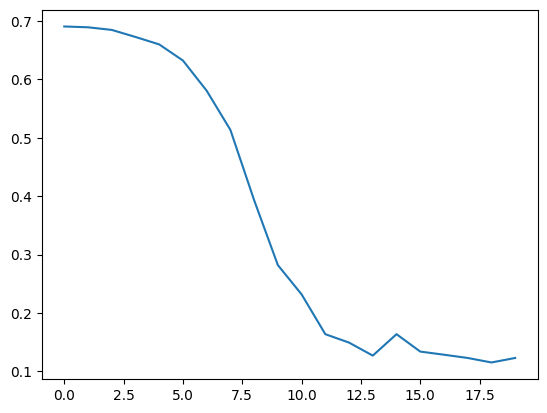

In [21]:
plt.plot([jnp.array(l).mean() for l in training_losses])

In [22]:
cel_loss = lambda logits, labels: (logits * labels).sum()

In [23]:
optax.softmax_cross_entropy(
    #logits= train_state.apply_fn({'params': train_state.params}, imgs),
    logits=state.apply_fn({'params': state.params}, test_imgs),
    labels=test_labels).sum()

Array(314.93677, dtype=float32)

In [24]:
optax.softmax_cross_entropy(
    logits=state.apply_fn({'params': state.params}, test_imgs_noisy),
    labels=test_labels_noisy).sum()

Array(1150.0137, dtype=float32)

[[0.14143713 0.8585629 ]]
[1. 0.]
[1.9559]


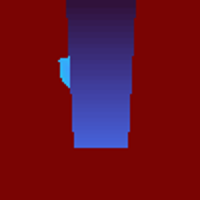

In [25]:
IDX = 2
__img = test_imgs[IDX].reshape(1, 100, 100, 1)
logits = state.apply_fn({'params': state.params}, __img)
print(b.utils.normalize_log_scores(logits))
print(test_labels[IDX])
print(optax.softmax_cross_entropy(
        #logits= train_state.apply_fn({'params': train_state.params}, imgs),
        logits=logits,
        labels=test_labels[IDX]))
b.viz.scale_image(b.get_depth_image(__img[0, :, :, 0]), 2)

In [26]:
logits = state.apply_fn({'params': state.params}, test_imgs)[:100, :]
b3d_logits = jnp.load('b3d_scores_no_noise.npy')


In [34]:
jnp.save('cnn_scores_no_noise.npy', logits)

In [27]:
for (l1, l2) in zip(jax.nn.softmax(logits),  jax.nn.softmax(b3d_logits)):
    print(l1, l2)

[0.00151398 0.99848604] [0. 1.]
[0.00370419 0.99629575] [0. 1.]
[0.14143726 0.85856277] [0.5 0.5]
[0.16887529 0.8311247 ] [0.5 0.5]
[0.00451189 0.9954881 ] [0. 1.]
[9.994188e-01 5.811581e-04] [1. 0.]
[0.16887529 0.8311247 ] [0.5 0.5]
[0.99876034 0.00123967] [0.5 0.5]
[0.1647268 0.8352732] [0.5 0.5]
[0.00164523 0.99835473] [0. 1.]
[0.99794394 0.00205606] [1. 0.]
[0.00310627 0.99689376] [0. 1.]
[0.00574108 0.9942589 ] [0. 1.]
[0.00165218 0.9983479 ] [0. 1.]
[0.00452231 0.9954777 ] [0. 1.]
[0.9977678  0.00223216] [0.5 0.5]
[0.00231552 0.9976845 ] [0. 1.]
[0.9983941  0.00160593] [1. 0.]
[0.9969369  0.00306312] [0.5 0.5]
[0.25285482 0.74714524] [0.5 0.5]
[0.99847454 0.00152541] [0.5 0.5]
[0.01410315 0.9858968 ] [5.169378e-25 1.000000e+00]
[0.00100826 0.9989918 ] [0. 1.]
[0.00435951 0.9956405 ] [0. 1.]
[0.9984433 0.0015567] [1. 0.]
[0.01267123 0.98732877] [0. 1.]
[0.00263944 0.9973605 ] [0. 1.]
[0.00201534 0.99798465] [0. 1.]
[0.00141264 0.9985873 ] [0. 1.]
[0.00210483 0.9978951 ] [0. 1.]
[0

In [28]:
# with open('param_file_1e5.pkl', 'wb') as params_file:
#     pickle.dump(state.params, params_file)

In [29]:
#img_batch, label_batch = make_batch(batch_keys)
#logits = state.apply_fn({'params': state.params}, img_batch)

In [30]:
#i = 33 #23 # 13

In [31]:
#b.viz.scale_image(b.get_depth_image(img_batch[i, :, :, 0]), 2)

In [32]:
#label_batch[i], jax.nn.softmax(logits[i])

## 